# 1. Spectrum and Light Curve Computation

Given the adoption of the DL3 + `Gammapy` analysis for crosschecks, these tutorials are a bit more advanced than those presented at the [previous F2F meeting](https://gitlab.pic.es/magic_dl3/point_like_analysis_tutorial) and at the [latest software school](https://gitlab.pic.es/magic_dl3/magic_dl3_sw_school_2023). For a complete novice introduction I refer you to these old tutorials and to the [`Gammapy` documentation](https://docs.gammapy.org/1.1/).

In this notebook, we will perform the basic computation of a one-dimensional analysis: spectrum and light curve. We will consider the 2020-2022 dataset of 1ES1959+650 to compute a long-term light curve and then estimate the daily spectra in a particular period of enhanced flux.

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import PointSkyRegion
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings

from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.data import DataStore, Observation
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.makers import (
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from plot_utils import plot_gammapy_lc_points, plot_gammapy_sed

warnings.filterwarnings("ignore")

## 1.1. Data reduction: from `Observations` to `Datasets`

 The `DataStore` objects allows to read all the fits files in a directory,
provided that we have generated and included in the folder two auxiliary files after we have produced the DL3 data: the `obs-index.fits.gz` and the `hdu-index.fits.gz`. [See this entry in the `magic_dl3` wiki](https://gitlab.pic.es/magic_dl3/magic_dl3/-/wikis/obs_hdu_index).

In [2]:
datastore = DataStore.from_dir("data/1ES1959+650/dl3")
observations = datastore.get_observations(required_irf=["rad_max", "aeff", "edisp"])

02/17/2024 12:44:41 PM|INFO|gammapy.data.data_store|Observations selected: 375 out of 375.


02/17/2024 12:44:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:42 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:42 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.


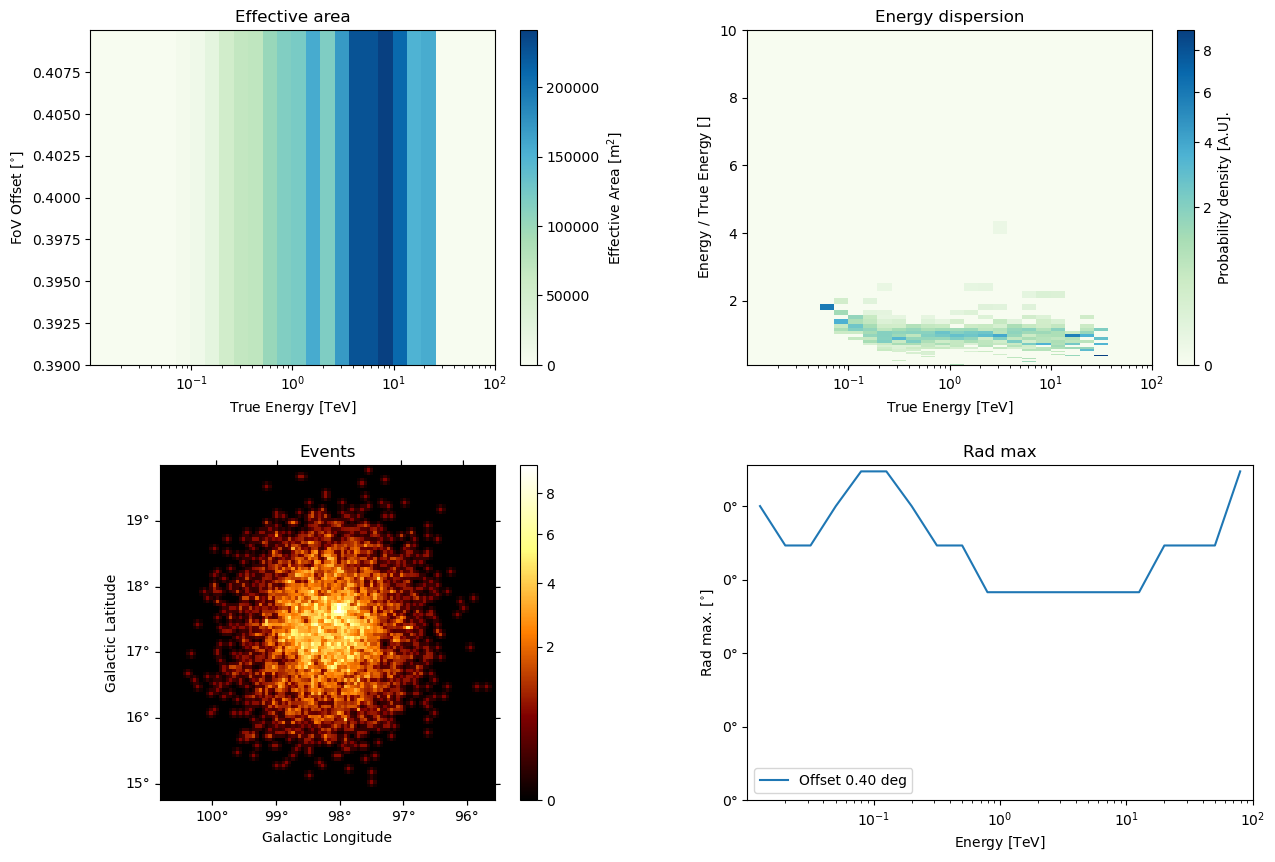

In [3]:
# each observation represent a DL3 file
observations[0].peek()

We do not need all the information in the `Observation` (i.e. in the DL3 file) for our analysis. As we aim to perform a one-dimensional analysis we need counts from the signal and background regions and a reduced version of the IRF components (computed at a specific offset in the camera offset). This data reduction is performed by the `SpectrumDatasetMaker`.

In [4]:
Image(url="figures/data_reduction.png", width=800, height=600)

I will illustrate just in this tutorial the steps of the data reduction, I will give it for granted in the next tutorials and will use a custom function to perform it

In [5]:
# parameters for the spectrum extraction
# energy axes
# estimated energy for the counts histograms
energy_axis = MapAxis.from_energy_bounds(
    10, 1e5, nbin=20, per_decade=False, unit="GeV", name="energy"
)
# true energy for folding (integrating) the IRF
# advice: make this denser than the estimated energy axis
energy_true_axis = MapAxis.from_energy_bounds(
    10, 1e5, nbin=28, per_decade=False, unit="GeV", name="energy_true"
)

# on region geometry
source_coordinates = SkyCoord.from_name("1ES1959+650")
on_region = PointSkyRegion(source_coordinates)
on_region_geom = RegionGeom.create(region=on_region, axes=[energy_axis])
# number of OFF regions
n_off_regions = 3

In [6]:
# create the blueprint for the dataset
dataset_empty = SpectrumDataset.create(
    geom=on_region_geom, energy_axis_true=energy_true_axis
)
# defines what is to be computed ("made")
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# finds the position of the OFF regions
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
# "makes" the OFF counts
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)


datasets = Datasets()

for observation in observations:
    # fills the ON counts and evaluates the IRF at the offset of interest
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fills the OFF counts
    dataset_on_off = bkg_maker.run(dataset, observation)

    datasets.append(dataset_on_off)

02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:44:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:44:59 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:01 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:10 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:12 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:20 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:31 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:31 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:31 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:31 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:31 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:39 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:44 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:46 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:46 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:46 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:46 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:46 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:47 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:49 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:55 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:45:57 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:57 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:57 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:45:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:03 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:05 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:14 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:16 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:22 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:24 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:24 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:24 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:24 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:24 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:33 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:35 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:41 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:43 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:45 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:48 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:50 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:52 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:54 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:56 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:46:58 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:00 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:02 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:04 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:05 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:06 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:07 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:08 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:09 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:11 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:13 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:15 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:17 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:19 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:21 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:23 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:24 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:25 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:26 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:26 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:26 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:26 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:27 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:28 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:30 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:32 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:34 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:36 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:38 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
02/17/2024 12:47:40 PM|WARNING|gammapy.maps.axes|'THETA' axis is stored as a scalar -- converting to 1D array.
0

We can take a moment to examine our dataset and set up, for example, the correct energy threshold for the analysis.

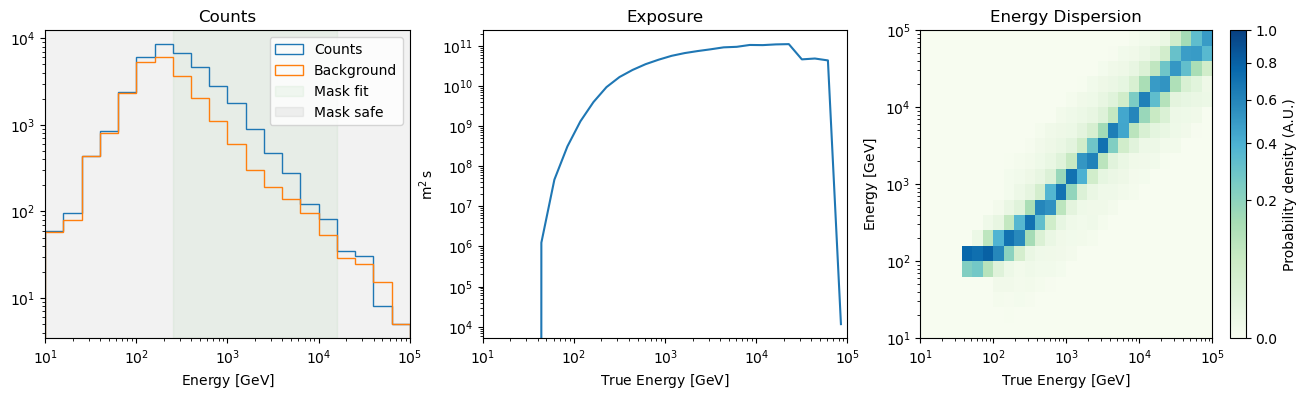

In [7]:
# to speed-up the fit - just for the average spectrum estimation - let us use the stacked dataset
dataset_stack = datasets.stack_reduce()

# apply proper minimum and maximum energy for the fit
e_min = 250 * u.GeV
e_max = 20 * u.TeV
dataset_stack.mask_fit = dataset_stack.counts.geom.energy_mask(e_min, e_max)

dataset_stack.peek()

To estimate the LC in `Gammapy` a spectral model is needed. We will use the one we obtain by fitting the stacked dataset (we can consider it as an "average" spectrum in these two years of observations).

In [8]:
# let us fit the whole dataset to obtain an average specturm that we will then use for the LC computation
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
# advice: if a LC with ULs has to be computed with this model, enlarge the amplitude range
spectral_model.parameters["amplitude"].min = 1e-15
spectral_model.parameters["amplitude"].max = 1e-7

model = SkyModel(spectral_model=spectral_model, name="1ES1959+650")

# assign the model to the dataset, don't forget this!
dataset_stack.models = [model]

In [9]:
fit = Fit()
results = fit.run(datasets=dataset_stack)
print(results)
print(spectral_model)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 96
	total stat : 12.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

LogParabolaSpectralModel

  type      name     value         unit        error      min       max    frozen is_norm link
-------- --------- ---------- -------------- --------- --------- --------- ------ ------- ----
spectral amplitude 6.3881e-12 TeV-1 s-1 cm-2 1.492e-13 1.000e-15 1.000e-07  False    True     
spectral reference 1.0000e+00            TeV 0.000e+00       nan       nan   True   False     
spectral     alpha 2.8022e+00                2.750e-02       nan       nan  False   False     
spectral      beta 2.0146e-01                3.095e-02       nan       nan  False   False     


In [10]:
# let us also compute flux points, to have a cross-check of the overall spectral shape
# I take the edges of the flux points from the estimated energy axis
energy_edges = energy_axis.edges[4:-3]

flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="1ES1959+650",
    selection_optional="all",
    n_sigma_ul=2,
)

flux_points = flux_points_estimator.run(datasets=dataset_stack)

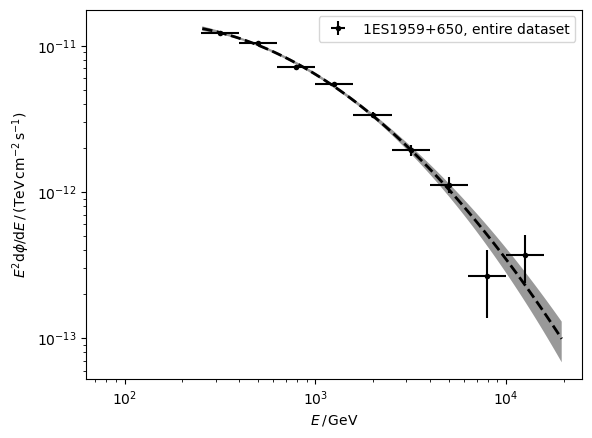

In [11]:
# make a plot of the spectrum
fig, ax = plt.subplots()

plot_gammapy_sed(
    ax, spectral_model, flux_points, e_min, e_max, "k", "1ES1959+650, entire dataset"
)
plt.legend()
plt.show()

## 1.2. Compute the light curve with different time binning

To investigate the variability of the source on different time scales, we will compute light curves with three different time binning: run-wise, weekly and monthly.

In [12]:
%%time
# assign the best-fit model to the joint datassets (note before we fitted the stacked one)
datasets.models = [model]

# first let's compute a run-wise LC
lc_maker_run_wise = LightCurveEstimator(
    energy_edges=[e_min, e_max],
    source="1ES1959+650",
    time_intervals=None,
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all",
    norm_min=0.2,
    norm_max=20,
    norm_n_values=200,
)
lc_run_wise = lc_maker_run_wise.run(datasets)

CPU times: user 4min 44s, sys: 2.41 s, total: 4min 46s
Wall time: 4min 47s


In [13]:
# let us make weekly and monthly time intervals and compute a weekly light curve
# this dataset starts in June 2020 and ends in August 2022
time_start = Time("2020-06-15", format="isot")
time_end = Time("2022-08-29", format="isot")
n_weeks = (time_end - time_start).to("week")
print(n_weeks)

# let us make the list of time intervals
weeks = [time_start + i * 7.0 * u.d for i in range(int(n_weeks.value) + 1)]

115.0 wk


In [14]:
# arrange the time intervals in the format accepted by the `LightCurveEstimator`
week_start = weeks[:-1]
week_end = weeks[1:]

weekly_time_intervals = [
    Time([tstart.mjd, tstop.mjd], format="mjd", scale="utc")
    for tstart, tstop in zip(week_start, week_end)
]

In [15]:
%%time
lc_maker_weekly = LightCurveEstimator(
    energy_edges=[e_min, e_max],
    source="1ES1959+650",
    time_intervals=weekly_time_intervals,
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all",
    norm_min=0.2,
    norm_max=20,
    norm_n_values=200,
)
lc_weekly = lc_maker_weekly.run(datasets)

02/17/2024 12:52:56 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59029.0 to 59036.0. Skipping interval.
02/17/2024 12:53:14 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59050.0 to 59057.0. Skipping interval.
02/17/2024 12:53:24 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59064.0 to 59071.0. Skipping interval.
02/17/2024 12:53:39 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59085.0 to 59092.0. Skipping interval.
02/17/2024 12:54:30 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59162.0 to 59169.0. Skipping interval.
02/17/2024 12:54:42 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59183.0 to 59190.0. Skipping interval.
02/17/2024 12:54:47 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59211.0 to 59218.0. Skipping interval.
02/17/2024 12:54:47 PM|INFO|gammapy.estim

02/17/2024 12:56:25 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59799.0 to 59806.0. Skipping interval.


CPU times: user 3min 37s, sys: 1.21 s, total: 3min 38s
Wall time: 3min 39s


In [16]:
# let us make a list of months
# this dataset starts in June 2020 and ends in August 2022
time_start = Time("2020-06-01", format="isot")
time_end = Time("2022-09-01", format="isot")
n_months = int((time_end - time_start).to_value("day") / 31)

months_number = np.arange(1, 13)
months_number = [f"0{int(i)}" if i < 10 else f"{int(i)}" for i in months_number]

# let us make the list of time intervals
months = [Time(f"2020-{month}-01", format="isot") for month in months_number]
months_2021 = [Time(f"2021-{month}-01", format="isot") for month in months_number]
months_2022 = [Time(f"2022-{month}-01", format="isot") for month in months_number]

months.extend(months_2021)
months.extend(months_2022)

In [17]:
# arrange the time intervals in the format accepted by the `LightCurveEstimator`
months_start = months[:-1]
months_end = months[1:]

monthly_time_intervals = [
    Time([tstart.mjd, tstop.mjd], format="mjd", scale="utc")
    for tstart, tstop in zip(months_start, months_end)
]

In [18]:
%%time
lc_maker_monthly = LightCurveEstimator(
    energy_edges=[e_min, e_max],
    source="1ES1959+650",
    time_intervals=monthly_time_intervals,
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all",
    norm_min=0.2,
    norm_max=20,
    norm_n_values=200,
)
lc_monthly = lc_maker_monthly.run(datasets)

02/17/2024 12:56:30 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 58849.0 to 58880.0. Skipping interval.
02/17/2024 12:56:30 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 58880.0 to 58909.0. Skipping interval.
02/17/2024 12:56:30 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 58909.0 to 58940.0. Skipping interval.
02/17/2024 12:56:31 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 58940.0 to 58970.0. Skipping interval.
02/17/2024 12:56:31 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 58970.0 to 59001.0. Skipping interval.
02/17/2024 12:58:26 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59215.0 to 59246.0. Skipping interval.
02/17/2024 12:58:26 PM|INFO|gammapy.estimators.points.lightcurve|No Dataset for the time interval 59246.0 to 59274.0. Skipping interval.
02/17/2024 12:59:07 PM|INFO|gammapy.estim

CPU times: user 3min 19s, sys: 953 ms, total: 3min 20s
Wall time: 3min 20s


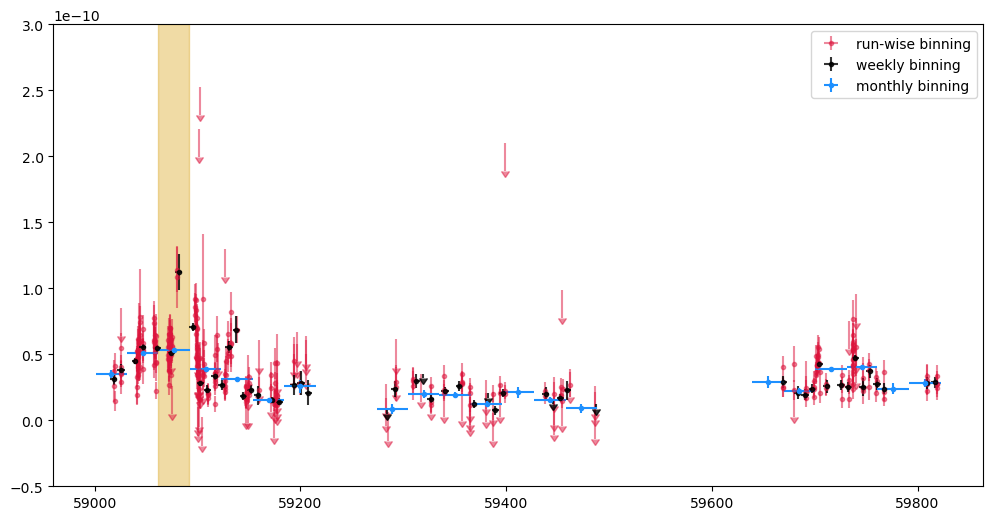

In [19]:
# arrange the time intervals in the format accepted by the `LightCurveEstimator`
fig, ax = plt.subplots(figsize=(12, 6))

time_min = Time("2020-08-01", format="isot")
time_max = Time("2020-08-31", format="isot")

plot_gammapy_lc_points(ax, lc_run_wise, "crimson", "run-wise binning", alpha=0.5)
plot_gammapy_lc_points(ax, lc_weekly, "k", "weekly binning", alpha=0.8)
plot_gammapy_lc_points(ax, lc_monthly, "dodgerblue", "monthly binning", alpha=1.0)
ax.axvspan(time_min.mjd, time_max.mjd, color="goldenrod", alpha=0.4)

ax.legend()
ax.set_ylim([-0.5e-10, 3e-10])
plt.show()

After having obtained the light curves with different binning, we realise, either by examining the data or by using some algorithm, that there is a significant period of higher emission that we wanted to further investigate. I marked, as an example, August 2020 in yellow. I will produce, in what follows, daily spectra for the month of August 2020. I use a power law for simplicity and repeat the same operations I performed for the "average" spectrum, I selecting this time the datasets in the day of interest with the `Datasets.select_time` function.

In [20]:
# let's compute the daily spectrum for all the days in August
time_min = Time("2020-08-01T12:00:00", format="isot")
time_max = Time("2020-08-31T12:00:00", format="isot")

In [21]:
spectral_models_dict = {}
flux_points_dict = {}

# let's perform the fit every 24 h
# let us considers times starting at mid-day in order to encompass a full observation night
# let us consider a power law for simplicity
for i in range(31):
    _time_min = time_min + i * 24 * u.h
    _time_max = time_min + (i + 1) * 24 * u.h

    try:
        dataset_daily = datasets.select_time(_time_min, _time_max).stack_reduce()
    except ValueError:
        print(f"No data between {_time_min} and {_time_max}")
        continue

    print(f"fitting data between {_time_min} and {_time_max}")
    # let us fit the dataset with a simple Power Law and compute flux points
    dataset_daily.mask_fit = dataset_daily.counts.geom.energy_mask(e_min, e_max)
    model_daily = SkyModel(spectral_model=PowerLawSpectralModel(), name="1ES1959+650")
    dataset_daily.models = [model_daily]

    results = fit.run(datasets=dataset_daily)
    print(results)
    flux_points = flux_points_estimator.run(datasets=dataset_daily)

    # let us save the results for future use
    spectral_models_dict[str(_time_min)] = dataset_daily.models[0].spectral_model
    flux_points_dict[str(_time_min)] = flux_points

No data between 2020-08-01T12:00:00.000 and 2020-08-02T12:00:00.000
No data between 2020-08-02T12:00:00.000 and 2020-08-03T12:00:00.000
No data between 2020-08-03T12:00:00.000 and 2020-08-04T12:00:00.000
No data between 2020-08-04T12:00:00.000 and 2020-08-05T12:00:00.000
No data between 2020-08-05T12:00:00.000 and 2020-08-06T12:00:00.000
No data between 2020-08-06T12:00:00.000 and 2020-08-07T12:00:00.000
No data between 2020-08-07T12:00:00.000 and 2020-08-08T12:00:00.000
No data between 2020-08-08T12:00:00.000 and 2020-08-09T12:00:00.000
fitting data between 2020-08-09T12:00:00.000 and 2020-08-10T12:00:00.000
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 93
	total stat : 9.84

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

fitting data between 2020-08-10T12:00:00.000 and 2020-08-11T12:00:00.000
OptimizeResult

	ba

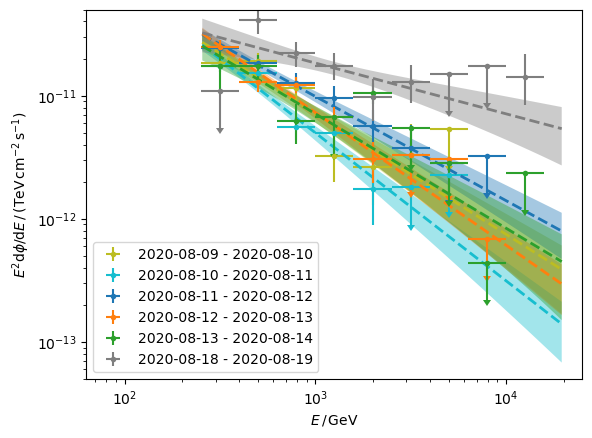

In [22]:
fig, ax = plt.subplots()

for i in range(31):
    _time_min = time_min + i * 24 * u.h
    _time_max = time_min + (i + 1) * 24 * u.h

    try:
        _spectral_model = spectral_models_dict[str(_time_min)]
        _flux_points = flux_points_dict[str(_time_min)]
    except KeyError:
        continue

    label = f"{str(_time_min).split('T')[0]} - {str(_time_max).split('T')[0]}"

    plot_gammapy_sed(
        ax,
        _spectral_model,
        _flux_points,
        e_min,
        e_max,
        f"C{i}",
        label,
    )

plt.legend()
ax.set_ylim([5e-14, 5e-11])
plt.show()